In [334]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error,mean_squared_error,make_scorer

In [3]:
DOWNLOAD_ROOT="http://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH=os.path.join("datasets","housing")
HOUSING_URL=DOWNLOAD_ROOT +"datasets/housing/housing.tgz"

In [5]:
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    os.makedirs(housing_path,exist_ok=TRUE)
    tgz_path=os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

In [11]:
def load_housing_data (housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [64]:
housing=pd.read_csv("C:/Users/krist/Desktop/Python learning/housing.csv")
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [17]:
housing.shape

(20640, 10)

In [19]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [21]:
#missing values in total_bedroom variable
housing.isna().sum() 

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [23]:
#checking what categories exist in this variable + their distinct count
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [26]:
#EDA of variables
prof = ProfileReport(housing, minimal=False) #use minimal=True for large datasets
prof.to_notebook_iframe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028C8023ABB0>,
      dtype=object)

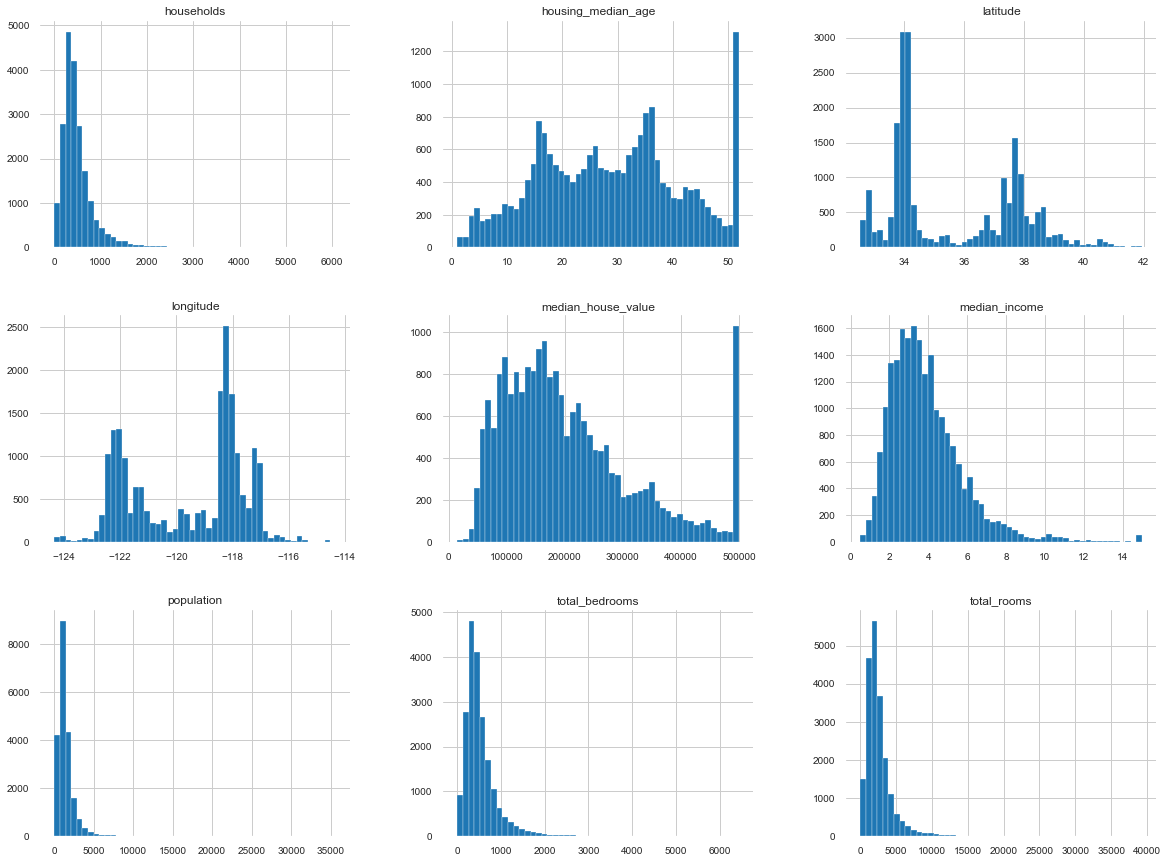

In [32]:
#plotting all numeric variables
housing.hist(bins=50,figsize=(20,15))

In [65]:
#Since median income correlates with median house value, we can create an income category attribute to ensure our train-test data
#will be representative of the income categories that exist in our dataset
housing["income_cat"]=pd.cut(housing["median_income"],bins=[0.,1.5,3,4.5,6,np.inf],labels=[1,2,3,4,5])

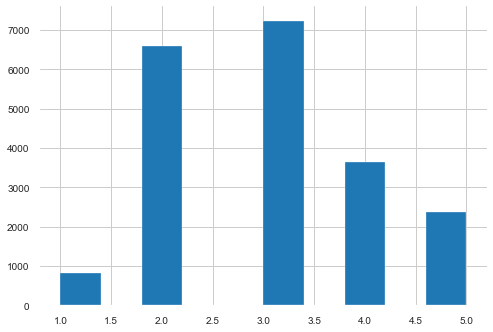

In [66]:
housing["income_cat"].hist()

In [67]:
#checking proportion of each income group in the whole data set to then compare it with stratified test set
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [68]:
#stratified train-test split
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing["income_cat"]):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]

In [70]:
#out stratified test set is representative of population (whole data set)
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [73]:
#removing income_cat variable since we don't need it anymore
strat_train_set.drop("income_cat",axis=1,inplace=True)
strat_test_set.drop("income_cat",axis=1,inplace=True)

In [84]:
#EDA

In [78]:
housing=strat_train_set.copy()

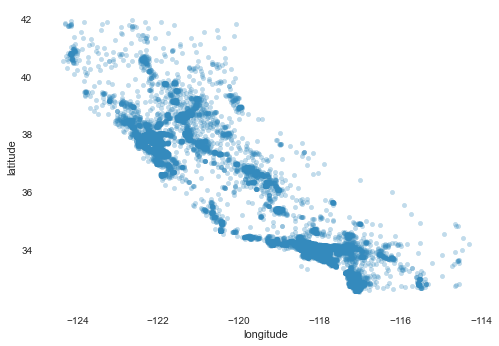

In [101]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.3)

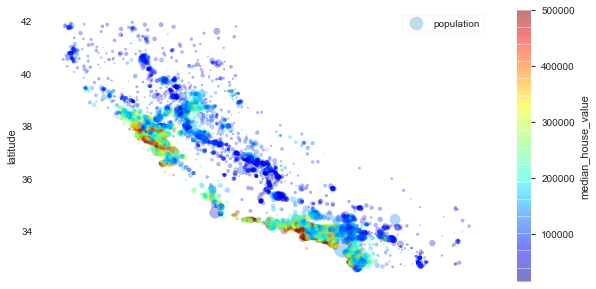

In [108]:
#houses near the ocean are more expensive
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.3,
            s=housing["population"]/100,label="population",figsize=(10,5),c="median_house_value",
             cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

In [112]:
#plotting correlation of each variable to target variable
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028CFCC113A0>,
      dtype=object)

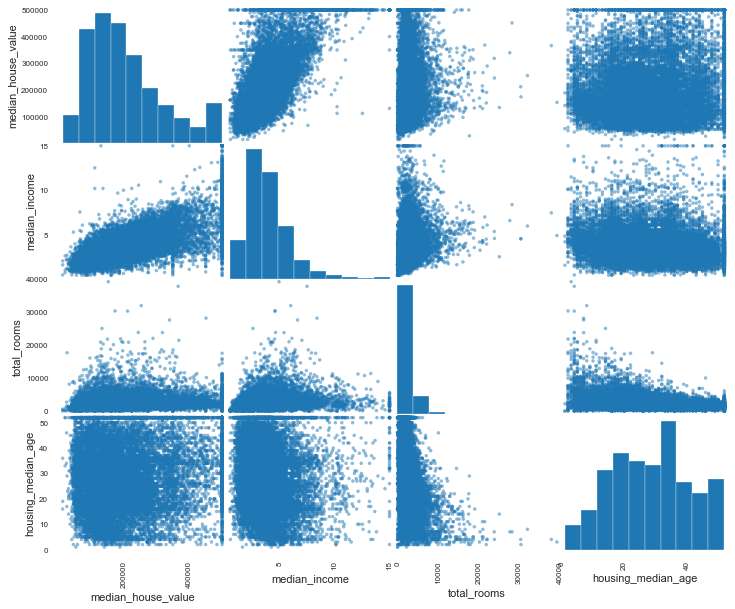

In [116]:
from pandas.plotting import scatter_matrix
attribute=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attribute],figsize=(12,10))

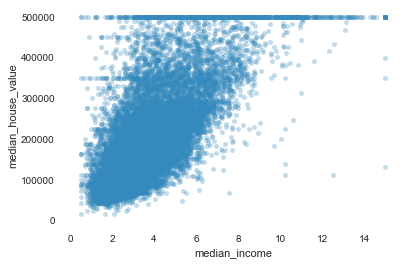

In [118]:
#there is a price cap at $500,000 that exists in data
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.3)

In [119]:
#FEATURE ENGINEERING

In [120]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [121]:
#DATA CLEANING

In [123]:
#separating label from data that will be cleaned
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [124]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy="median")

In [125]:
#since median can be only computed on numeric values, we need to separate 1 categorical variable
housing_num=housing.drop("ocean_proximity",axis=1)

In [127]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [128]:
X=imputer.transform(housing_num)

In [130]:
#putting newly created array of imputed value back into our data frame
housing_transformed=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

In [133]:
housing_transformed.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214  
14650       936.0       462.0         2.8621  
3230       1460.0       353.0         1.8839  
3555       4459.0      1463.0         3.0347

In [135]:
housing_transformed.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

In [152]:
housing_cat=housing[["ocean_proximity"]]
housing_cat.head()

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN

In [148]:
#converting categorical variable to dummies for further modeling
#housing_cat=pd.get_dummies(housing_cat["ocean_proximity"])

In [151]:
#housing_cat

<1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
17606          1       0       0         0           0
18632          1       0       0         0           0
14650          0       0       0         0           1
3230           0       1       0         0           0
3555           1       0       0         0           0
...          ...     ...     ...       ...         ...
6563           0       1       0         0           0
12053          0       1       0         0           0
13908          0       1       0         0           0
11159          1       0       0         0           0
15775          0       0       0         1           0

[16512 rows x 5 columns]

In [155]:
#we can use OneHotEncoder to transform categorical variable
from sklearn.preprocessing import OneHotEncoder
cat_encoder=OneHotEncoder()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [170]:
#setting up the pipeline for numeric variables
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline=Pipeline([("imputer",SimpleImputer(strategy="median")),
                      ("scaler",StandardScaler())])

In [172]:
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [211]:
#or we can apply transformation to both numeric and categorical variables using ColumnTransformer!
from sklearn.compose import ColumnTransformer
housing=strat_train_set.drop("median_house_value",axis=1)
housing_num=housing.drop("ocean_proximity",axis=1)

num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]

full_pipeline=ColumnTransformer([("num",num_pipeline,num_attribs),
                                ("cat",OneHotEncoder(),cat_attribs)])

housing_prepared=full_pipeline.fit_transform(housing)

In [226]:
#house=pd.DataFrame(housing_prepared,columns=housing.columns,index=housing.index)

ValueError: Shape of passed values is (16512, 13), indices imply (16512, 9)

In [212]:
#trying simple linear regression
from sklearn.linear_model import LinearRegression

housing_labels=strat_train_set["median_house_value"].copy()
reg=LinearRegression()
reg=reg.fit(housing_prepared,housing_labels)

In [213]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

In [214]:
#measuring model performance on whole training set
housing_pred=reg.predict(housing_prepared)
rmse=np.sqrt(mean_squared_error(housing_labels,housing_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 69050.98178244587


In [215]:
#trying decision tree
from sklearn.tree import DecisionTreeRegressor
tree=DecisionTreeRegressor()
tree=tree.fit(housing_prepared,housing_labels)

In [216]:
#measuring model performance on whole training set
housing_pred=tree.predict(housing_prepared)
rmse=np.sqrt(mean_squared_error(housing_labels,housing_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.0


In [217]:
for i, item in enumerate(tree.feature_importances_):
    print(housing_prepared.columns[i],item)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [223]:
#conducting cross-validation
from sklearn.model_selection import cross_val_score
#mae_scorer=make_scorer(mean_absolute_error)
cv_scores=cross_val_score(tree,housing_prepared,housing_labels,cv=10,scoring="neg_mean_squared_error")
tree_rmse_scores=np.sqrt(-cv_scores)

In [225]:
tree_rmse_scores

array([66807.10138295, 66517.7161662 , 73158.98675642, 70386.70580534,
       68348.46378522, 74349.41038439, 68237.62383846, 69771.01445661,
       70319.31158386, 70104.50201799])

In [228]:
tree_rmse_scores.mean() #mean rmse is high

69800.08361774446

In [232]:
#checking linear regression using cross-validation to double check in dt is really overfitting 
cv_scores=cross_val_score(reg,housing_prepared,housing_labels,cv=10,scoring="neg_mean_squared_error")
reg_rmse_scores=np.sqrt(-cv_scores)
reg_rmse_scores.mean()

69223.18594556302

In [248]:
#trying random forest
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
cv_scores=cross_val_score(rf,housing_prepared,housing_labels,cv=10,scoring="neg_mean_squared_error")
rf_rmse_scores=np.sqrt(-cv_scores)
rf_rmse_scores.mean()

49555.63360381204

In [298]:
from sklearn.svm import SVC
SVM=SVC()
cv_scores=cross_val_score(SVM,housing_prepared,housing_labels,cv=10,scoring="neg_mean_squared_error")
SVM_rmse_scores=np.sqrt(-cv_scores)
SVM_rmse_scores.mean()

C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


KeyboardInterrupt: 

In [299]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso=Lasso()
cv_scores=cross_val_score(lasso,housing_prepared,housing_labels,cv=10,scoring="neg_mean_squared_error")
lasso_rmse_scores=np.sqrt(-cv_scores)
lasso_rmse_scores.mean()

C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5843215559653.273, tolerance: 20117038531.25574
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5815913830818.953, tolerance: 19833211712.8081
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5823178521723.859, tolerance: 19917705466.961983
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

69223.3549614288

In [300]:
from sklearn.linear_model import Ridge
ridge=Ridge()
cv_scores=cross_val_score(ridge,housing_prepared,housing_labels,cv=10,scoring="neg_mean_squared_error")
ridge_rmse_scores=np.sqrt(-cv_scores)
ridge_rmse_scores.mean()

69224.13512958627

In [301]:
#TUNING MODEL

In [326]:
# Lasso alues we would like to check.
ALPHAS = [0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0, 250.0, 500.0]

# Parameter grid is a way to provide parameters to iterate.
param_grid = {
    'alpha' : ALPHAS,
    'selection' : ['cyclic', 'random'],
    'max_iter':[1000,2000,3000],
    'normalize':[True,False]
}

# Initializing and fitting.
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5, refit=True, scoring="neg_mean_squared_error")
lasso_cv.fit(housing_prepared, housing_labels)

C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025790119641.2188, tolerance: 17846214224.00758
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975244588153.289, tolerance: 17637185401.459282
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1983120093565.6016, tolerance: 17604186442.621544
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5152284052235.758, tolerance: 17604186442.621544
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5233413700996.461, tolerance: 17633416521.28389
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5180729532059.031, tolerance: 17691055977.088455
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1983173708976.5625, tolerance: 17604186442.621544
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2012523172678.5234, tolerance: 17633416521.28389
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2001656208693.9219, tolerance: 17691055977.088455
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025911374670.6562, tolerance: 17846214224.00758
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975369858725.8672, tolerance: 17637185401.459282
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1983240403544.1406, tolerance: 17604186442.621544
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5233442741200.734, tolerance: 17633416521.28389
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5180756660136.352, tolerance: 17691055977.088455
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2027056890815.0469, tolerance: 17846214224.00758
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33468709243.734375, tolerance: 17846214224.00758
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5185774510895.773, tolerance: 17846214224.00758
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5095939944151.445, tolerance: 17637185401.459282
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5234785738458.852, tolerance: 17633416521.28389
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5182005432314.6875, tolerance: 17691055977.088455
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16630436601559.793, tolerance: 17691055977.088455
  model = cd_fast.enet_coordinate_descent(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5,
                                   1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0,
                                   250.0, 500.0],
                         'max_iter': [1000, 2000, 3000],
                         'normalize': [True, False],
                         'selection': ['cyclic', 'random']},
             scoring='neg_mean_squared_error')

In [327]:
lasso_cv=lasso_cv.best_estimator_

In [329]:
lasso_cv

Lasso(alpha=0.5, max_iter=3000, normalize=True, selection='random')

In [331]:
#conducting cross-validation on best tuned Lasso model
cv_scores=cross_val_score(lasso_cv,housing_prepared,housing_labels,cv=10,scoring="neg_mean_squared_error")
lasso_rmse_scores=np.sqrt(-cv_scores)
lasso_rmse_scores.mean() #performed almost the same as non-reguralized

69223.22249303809

In [333]:
#Tuning Ridge
# Set of parameters to check.
ALPHAS = (0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0, 250.0, 500.0)

# Parameter grid is a way to provide parameters to iterate.
param_grid = {
    'alpha' : ALPHAS,
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter':[1000,2000,3000],
    'normalize':[True]
}

# Initializing and fitting.
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5, refit=True, scoring="neg_mean_squared_error")
ridge_cv.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': (0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5,
                                   1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0,
                                   250.0, 500.0),
                         'max_iter': [1000, 2000, 3000], 'normalize': [True],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             scoring='neg_mean_squared_error')

In [337]:
ridge_cv=ridge_cv.best_estimator_

In [338]:
#conducting cross-validation on best tuned Lasso model
cv_scores=cross_val_score(ridge_cv,housing_prepared,housing_labels,cv=10,scoring="neg_mean_squared_error")
ridge_rmse_scores=np.sqrt(-cv_scores)
ridge_rmse_scores.mean() #performed almost the same as non-reguralized

69215.91887340476

In [270]:
#Tuning RandomForest as it has performed the best on cross-validation
from sklearn.model_selection import GridSearchCV

parameters=[
    {'n_estimators': [3,10,30,40], 'max_features': [2,4,6,7,10],"max_depth":[3,15,20,30]},
    {'bootstrap': [False], 'n_estimators': [3,10],'max_features': [2, 3, 4],"max_depth":[5,10,15,20]},
  ]
rf=RandomForestRegressor()
grid_search=GridSearchCV(rf,param_grid=parameters,cv=5, scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [3, 15, 20, 30],
                          'max_features': [2, 4, 6, 7, 10],
                          'n_estimators': [3, 10, 30, 40]},
                         {'bootstrap': [False], 'max_depth': [5, 10, 15, 20],
                          'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [339]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=20, max_features=10, n_estimators=40)

In [274]:
feature_importance=grid_search.best_estimator_.feature_importances_
feature_importance

array([1.07366369e-01, 1.00383565e-01, 5.18977058e-02, 2.79547606e-02,
       2.41140596e-02, 3.45123275e-02, 2.29220229e-02, 4.71231925e-01,
       4.45028555e-03, 1.47773631e-01, 3.16107097e-05, 1.46895873e-03,
       5.89277851e-03])

In [279]:
#assigning back attribute names 
cat_encoder=full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs=list(cat_encoder.categories_[0])
attributes=num_attribs+cat_one_hot_attribs
sorted(zip(feature_importance,attributes),reverse=True)

[(0.47123192473106873, 'median_income'),
 (0.14777363137353228, 'INLAND'),
 (0.10736636918355365, 'longitude'),
 (0.10038356483410212, 'latitude'),
 (0.05189770575010836, 'housing_median_age'),
 (0.034512327538746265, 'population'),
 (0.02795476063050184, 'total_rooms'),
 (0.024114059592651386, 'total_bedrooms'),
 (0.02292202286638633, 'households'),
 (0.0058927785117292835, 'NEAR OCEAN'),
 (0.004450285547838086, '<1H OCEAN'),
 (0.001468958730104729, 'NEAR BAY'),
 (3.161070967696578e-05, 'ISLAND')]

In [291]:
final_model=grid_search.best_estimator_

In [286]:
X_test=strat_test_set.drop("median_house_value",axis=1)
y_test=strat_test_set["median_house_value"].copy()

X_test_preraped=full_pipeline.transform(X_test)

In [289]:
final_predictions=final_model.predict(X_test_preraped)

In [290]:
final_predictions

array([492225.775     , 223836.09986609, 204377.12103299, ...,
       263639.45596639, 148457.13040458,  98917.5       ])

In [294]:
final_rmse=np.sqrt(mean_squared_error(y_test,final_predictions))
print("Root Mean Squared Error: {}".format(final_rmse))

Root Mean Squared Error: 47384.44904669321


In [297]:
#constructing 95% confidence interval
from scipy import stats
confidence=0.95
squared_errors=(final_predictions-y_test)**2
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,
       loc=squared_errors.mean(),
       scale=stats.sem(squared_errors)))

array([45459.53073178, 49234.16586643])